In [1]:
#package imports

from ase.io import read,write 
from ase.visualize import view
from ase.build import add_adsorbate
from ase.constraints import FixAtoms
from ase.neighborlist import NeighborList,build_neighbor_list, natural_cutoffs,primitive_neighbor_list,neighbor_list
from ase.geometry import get_distances,distance
from ase import symbols
from ase.geometry import Cell

import numpy as np

import mendeleev as mendel
from mendeleev import Co,Cu,Fe,Ni,Mo
from numpy import genfromtxt

import time

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

import pandas as pd
from pandas import unique

from joblib import Parallel, delayed
import multiprocessing

from random import shuffle
import math 
import time

from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
#from sklearn.model_selection.learning_curve import plot_learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv("Equiatomic_alloys_filled.csv")
df2 = df.drop(df[df.Phase=='none'].index)
df_labels= df2['Phase']
df_descriptors = df2.drop(['Phase','composition'],axis=1)
df2.head(5)

,composition,melting_point,atomic_size_difference,mixing_entropy,mixing_enthalpy,electronegativity,VEC,Phase
1,AgAlAuCu,1215.875,9.318991,11.526293,-11.413999,0.338563,9.00,fcc
17,AgAuCoIr,1769.815,7.663942,11.526293,11.312749,0.262333,10.00,fcc
19,AgAuCoNi,1517.065,7.663942,11.526293,10.755974,0.274818,10.25,fcc
23,AgAuCoRh,1644.315,7.663942,11.526293,8.806409,0.269293,10.00,fcc
26,AgAuCrNi,1620.065,7.233519,11.526293,9.270347,0.323960,9.50,fcc


In [3]:
scaler = StandardScaler()
scaler.fit(df_descriptors)
normalized_des = scaler.transform(df_descriptors)

In [4]:
labels = np.zeros((df_descriptors.shape[0],1))
arr = df_labels.to_numpy()

x1 = 0
x2 = 0
for i in range(df_descriptors.shape[0]):
    if arr[i] == 'fcc':
        labels[i] = 1
        x1 += 1
    elif arr[i] == 'bcc':
        labels[i] = 0
        x2 += 1
    else:
        print('neither',str(i))
print(x1,x2)

242 264


In [5]:
X_train, X_test, y_train, y_test = train_test_split(normalized_des,labels, test_size=0.15)
y_train = y_train.astype(int)
y_test = y_test.astype(int)
#y_test.reshape(y_test.shape[0],)
X_test.shape

(76, 6)

In [6]:
clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(5, 2),validation_fraction=0.15,random_state=1,max_iter = 1000)
clf.fit(X_train,np.ravel(y_train))

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), max_iter=1000,
              random_state=1, solver='sgd', validation_fraction=0.15)

In [7]:
clf.get_params

<bound method BaseEstimator.get_params of MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), max_iter=1000,
              random_state=1, solver='sgd', validation_fraction=0.15)>

In [8]:
coefs = clf.coefs_
print(coefs[0].shape,coefs[1].shape,coefs[2].shape,X_train.shape) 
coefs

(6, 5) (5, 2) (2, 1) (430, 6)


[array([[-0.25323249,  0.60454671, -0.29550474, -0.03826873, -0.4100739 ],
        [-0.60646996, -0.50041092, -0.20237929, -0.16569377,  0.0294853 ],
        [-0.12580314,  0.28223942, -0.40669022,  0.5413347 , -0.76454961],
        [ 0.21712941, -0.01685853,  0.0458761 , -0.41934533, -0.25980079],
        [ 0.42725752,  0.80705577, -0.08285022,  0.31468631,  0.34154778],
        [ 0.63308296, -0.93175361, -1.47420945, -0.78056291,  0.7625451 ]]),
 array([[-0.44820723,  0.25118751],
        [ 1.23094947, -0.80710705],
        [ 1.05709591,  1.05986274],
        [ 0.71603849, -0.32942425],
        [-0.161236  , -0.91930101]]),
 array([[-1.57499822],
        [-0.61223361]])]

In [9]:
layer1_weights = coefs[0]
layer1_weights = tf.constant_initializer(layer1_weights)

layer2_weights = coefs[1]
layer2_weights = tf.constant_initializer(layer2_weights)

layer3_weights = coefs[2]
layer3_weights = tf.constant_initializer(layer3_weights)

print(layer1_weights,layer2_weights,layer3_weights)

<tensorflow.python.ops.init_ops_v2.Constant object at 0x7faad140dfa0> <tensorflow.python.ops.init_ops_v2.Constant object at 0x7faad140dca0> <tensorflow.python.ops.init_ops_v2.Constant object at 0x7faad140dfd0>


In [10]:
bias = clf.intercepts_
bias

[array([-0.54157393,  0.22191088,  0.73750254,  0.25122423,  0.42255403]),
 array([-0.04020766,  0.48543019]),
 array([2.01320656])]

In [11]:
layer1_bias = bias[0]
layer1_bias = tf.constant_initializer(layer1_bias)

layer2_bias = bias[1]
layer2_bias = tf.constant_initializer(layer2_bias)

layer3_bias = bias[2]
layer3_bias = tf.constant_initializer(layer3_bias)

print(layer1_bias,layer2_bias,layer3_bias)

<tensorflow.python.ops.init_ops_v2.Constant object at 0x7faae5ea0f40> <tensorflow.python.ops.init_ops_v2.Constant object at 0x7faad1744250> <tensorflow.python.ops.init_ops_v2.Constant object at 0x7faad17442b0>


## Initialized model

In [12]:
n_cols = X_train.shape[1]

def get_model():
    
    model = Sequential()
    model.add(Dense(5, activation='relu',input_shape=(n_cols,),name='should_be_6x5',
                    kernel_initializer=layer1_weights,bias_initializer=layer1_bias))
    
    model.add(Dense(2, activation='relu',name='should_be_5x2',
             kernel_initializer=layer2_weights,bias_initializer=layer2_bias))
    
    model.add(Dense(1,name='should_be_2x1',
                   kernel_initializer=layer3_weights,bias_initializer=layer3_bias))

    opt = tf.keras.optimizers.SGD(learning_rate=1e-05, momentum=0.0, nesterov=False)
    
    l = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.0, axis=-1)
    
    model.compile(optimizer=opt,loss=l, metrics=['accuracy'])
    return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
should_be_6x5 (Dense)        (None, 5)                 35        
_________________________________________________________________
should_be_5x2 (Dense)        (None, 2)                 12        
_________________________________________________________________
should_be_2x1 (Dense)        (None, 1)                 3         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(X_train, y_train, epochs=500,validation_data=(X_test,y_test))

Epoch 1/500
14/14 [==============================] - 1s 12ms/step - loss: 0.0051 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 2/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 3/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 4/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 5/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 6/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 7/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 8/500


Epoch 59/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 60/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 61/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 62/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 63/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 64/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 65/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 

14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 117/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 118/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 119/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 120/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 121/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 122/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 123/500

14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 174/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 175/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 176/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 177/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 178/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 179/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 180/500

14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 231/500
14/14 [==============================] - 0s 3ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 232/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 233/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 234/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 235/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 236/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 237/500

14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 288/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 289/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 290/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 291/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 292/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 293/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 294/500

14/14 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 345/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 346/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 347/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 348/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 349/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 350/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 351/500

14/14 [==============================] - 0s 3ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 402/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 403/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 404/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 405/500
14/14 [==============================] - 0s 3ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 406/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 407/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 408/500

14/14 [==============================] - 0s 3ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 459/500
14/14 [==============================] - 0s 3ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 460/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 461/500
14/14 [==============================] - 0s 3ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 462/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 463/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 464/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9977 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 465/500

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


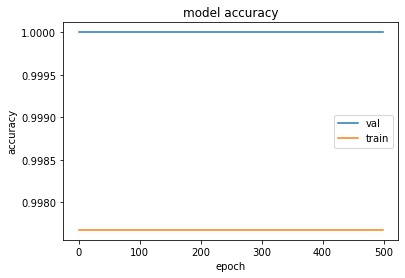

In [14]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['val_accuracy'],label='val')
plt.plot(history.history['accuracy'],label='train')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

### Sklearn performance

In [15]:
yhat = clf.predict(X_test)
yhat2 = clf.predict(X_train)
accuracy_score(y_test, yhat)

0.9868421052631579

In [80]:
labels=clf.classes_
print(labels)
labels2 = ['BCC','FCC']

[0 1]


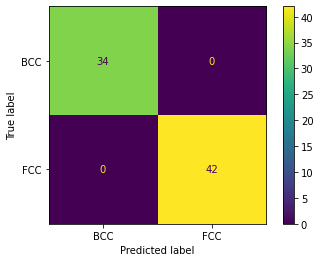

In [81]:
cm = confusion_matrix(y_test, yhat, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels2)
disp.plot()

In [17]:
#Function to plot learning curves

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

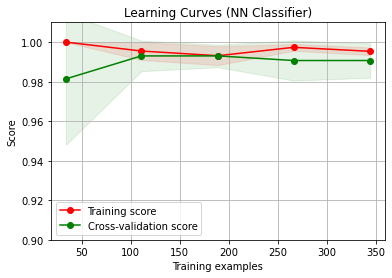

In [18]:
title = "Learning Curves (NN Classifier)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#estimator = RandomForestClassifier(n_estimators=200)
plot_learning_curve(clf, title, X_train, y_train, ylim=(0.9, 1.01), cv=cv, n_jobs=4)
#plt.savefig('books_read.png')